In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.CPPN1 import CPPN1training
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 100
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
load_layer = CPPN1()
load_layer.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(load_layer)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
print(len(list(load_layer.children())))

4


In [6]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [7]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []
layer_count = len(list(load_layer.children()))


def normalize(tensor, axis):
    if axis % 2 == 0:
        max_vals = layer_count
        min_vals = 0
    else:
        max_vals, _ = torch.max(tensor, dim=0)
        min_vals, _ = torch.min(tensor, dim=0)

    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in load_layer.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
        normal = temp_coords
        print(temp_coords)
        for i in range(4):
            # print(i)
            normal[:,i] = normalize(temp_coords[:, i], i)
            # normal = torch.nan_to_num(normal, nan = 0)
        if index == 3:
            # print(temp_coords)
            print(normal)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)

# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

        

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  0.,  1.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  2.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  0.,  1.,  3.],
        [ 0.,  1.,  1.,  3.],
        [ 0.,  0.,  1.,  4.],
        [ 0.,  1.,  1.,  4.],
        [ 0.,  0.,  1.,  5.],
        [ 0.,  1.,  1.,  5.],
        [ 0.,  0.,  1.,  6.],
        [ 0.,  1.,  1.,  6.],
        [ 0.,  0.,  1.,  7.],
        [ 0.,  1.,  1.,  7.],
        [ 0.,  0.,  1.,  8.],
        [ 0.,  1.,  1.,  8.],
        [ 0.,  0.,  1.,  9.],
        [ 0.,  1.,  1.,  9.],
        [ 0.,  0.,  1., 10.],
        [ 0.,  1.,  1., 10.],
        [ 0.,  0.,  1., 11.],
        [ 0.,  1.,  1., 11.],
        [ 0.,  0.,  1., 12.],
        [ 0.,  1.,  1., 12.],
        [ 0.,  0.,  1., 13.],
        [ 0.,  1.,  1., 13.],
        [ 0.,  0.,  1., 14.],
        [ 0.,  1.,  1., 14.],
        [ 0.,  0.,  1., 15.],
        [ 0.,  1.,  1., 15.],
        [ 0.,  0.,  1., 16.],
        [ 

#### Set up CPPN_squared

In [8]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [9]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [10]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [11]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.1470, 0.6746, 0.5860,  ..., 0.5025, 0.4696, 0.5333], device='cuda:0')


#### Split training and validation set


In [12]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
# train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
# batch_size = int(batch_size * 0.9)

In [13]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -0.5000, -1.0000],
        [-1.0000,  1.0000, -0.5000, -1.0000],
        [-1.0000, -1.0000, -0.5000, -0.9683],
        ...,
        [ 0.5000,  0.9365,  1.0000,  1.0000],
        [ 0.5000,  0.9683,  1.0000,  1.0000],
        [ 0.5000,  1.0000,  1.0000,  1.0000]], device='cuda:0')


#### This is where I put the training loop of CPPN1 into CPPN Squared

In [14]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

for i in range(num_steps):
    all_target_weights = CPPN1training.run_loop()
    all_target_weights = torch.tensor(all_pixel_values, device=device, dtype=torch.float32)
    train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_target_weights, test_size=0.1, random_state=42)
    
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))

    training_coords_batch = normalized_coords_matrix[training_batch_indexes]

    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)

    approx_pixel_values = CPPN_squared(training_coords_batch)

    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0

            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

C:\Users\stere\AppData\Local\Temp\ipykernel_18336\2631047938.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_target_weights = torch.tensor(all_pixel_values, device=device, dtype=torch.float32)


step 0, loss 0.296
Validation - Step 0, loss 0.296
step 1, loss 0.276
Validation - Step 1, loss 0.276
step 2, loss 0.257
Validation - Step 2, loss 0.258
step 3, loss 0.239
Validation - Step 3, loss 0.240
step 4, loss 0.222
Validation - Step 4, loss 0.223
step 5, loss 0.205
Validation - Step 5, loss 0.206
step 6, loss 0.189
Validation - Step 6, loss 0.191
step 7, loss 0.174
Validation - Step 7, loss 0.176
step 8, loss 0.159
Validation - Step 8, loss 0.162
step 9, loss 0.146
Validation - Step 9, loss 0.148
step 10, loss 0.133
Validation - Step 10, loss 0.135
step 11, loss 0.120
Validation - Step 11, loss 0.123
step 12, loss 0.109
Validation - Step 12, loss 0.112
step 13, loss 0.098
Validation - Step 13, loss 0.101
step 14, loss 0.088
Validation - Step 14, loss 0.091
step 15, loss 0.078
Validation - Step 15, loss 0.081
step 16, loss 0.070
Validation - Step 16, loss 0.073
step 17, loss 0.061
Validation - Step 17, loss 0.064
step 18, loss 0.054
Validation - Step 18, loss 0.057
step 19, loss

In [15]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.5094, 0.5320, 0.5106, 0.5323, 0.5118, 0.5326, 0.5129, 0.5329, 0.5140,
        0.5332, 0.5150, 0.5334, 0.5161, 0.5337, 0.5170, 0.5339, 0.5179, 0.5341,
        0.5188, 0.5343, 0.5196, 0.5345, 0.5204, 0.5347, 0.5212, 0.5349, 0.5219,
        0.5350, 0.5225, 0.5352, 0.5231, 0.5353, 0.5236, 0.5354, 0.5241, 0.5355,
        0.5246, 0.5356, 0.5250, 0.5356, 0.5253, 0.5357, 0.5256, 0.5357, 0.5259,
        0.5357, 0.5261, 0.5357, 0.5262, 0.5357, 0.5263, 0.5356, 0.5264, 0.5355,
        0.5264, 0.5355, 0.5263, 0.5353, 0.5262, 0.5352, 0.5260, 0.5351, 0.5258,
        0.5349, 0.5255, 0.5347, 0.5252, 0.5345, 0.5248, 0.5342, 0.5244, 0.5340,
        0.5239, 0.5337, 0.5233, 0.5334, 0.5227, 0.5331, 0.5221, 0.5327, 0.5214,
        0.5323, 0.5206, 0.5319, 0.5198, 0.5315, 0.5189, 0.5310, 0.5180, 0.5305,
        0.5170, 0.5300, 0.5159, 0.5295, 0.5148, 0.5289, 0.5137, 0.5283, 0.5125,
        0.5277, 0.5112, 0.5271, 0.5099, 0.5264, 0.5085, 0.5257, 0.5071, 0.5249,
        0.5056, 0.5242, 0.5041, 0.5234, 

In [16]:
print(all_pixel_values)

tensor([0.1470, 0.6746, 0.5860, 0.4835, 0.4479, 0.2837, 0.8141, 0.4256, 0.6251,
        0.5235, 0.3447, 0.5406, 0.6934, 0.4662, 0.6846, 0.4326, 0.2561, 0.2245,
        0.8096, 0.6139, 0.8166, 0.4499, 0.6902, 0.3670, 0.1531, 0.8327, 0.2182,
        0.2398, 0.3247, 0.4700, 0.4820, 0.8240, 0.8220, 0.4103, 0.3475, 0.7358,
        0.5842, 0.4290, 0.2675, 0.3891, 0.7060, 0.3460, 0.2834, 0.4795, 0.7627,
        0.6379, 0.4675, 0.3595, 0.3021, 0.8493, 0.2772, 0.4039, 0.7299, 0.6327,
        0.7489, 0.2789, 0.6629, 0.7428, 0.6447, 0.5534, 0.3020, 0.3269, 0.3824,
        0.6074, 0.2975, 0.6769, 0.4471, 0.7602, 0.8183, 0.6741, 0.2913, 0.2136,
        0.7910, 0.1562, 0.6091, 0.3963, 0.7422, 0.3348, 0.5215, 0.5064, 0.6049,
        0.7754, 0.6710, 0.1544, 0.5257, 0.2475, 0.2358, 0.2374, 0.7338, 0.3720,
        0.4533, 0.4022, 0.5662, 0.6812, 0.2782, 0.7367, 0.1794, 0.3665, 0.3736,
        0.6864, 0.8131, 0.5041, 0.5154, 0.6227, 0.5409, 0.4366, 0.2028, 0.2207,
        0.3659, 0.2524, 0.5433, 0.7567, 

Text(0.5, 1.0, 'target')

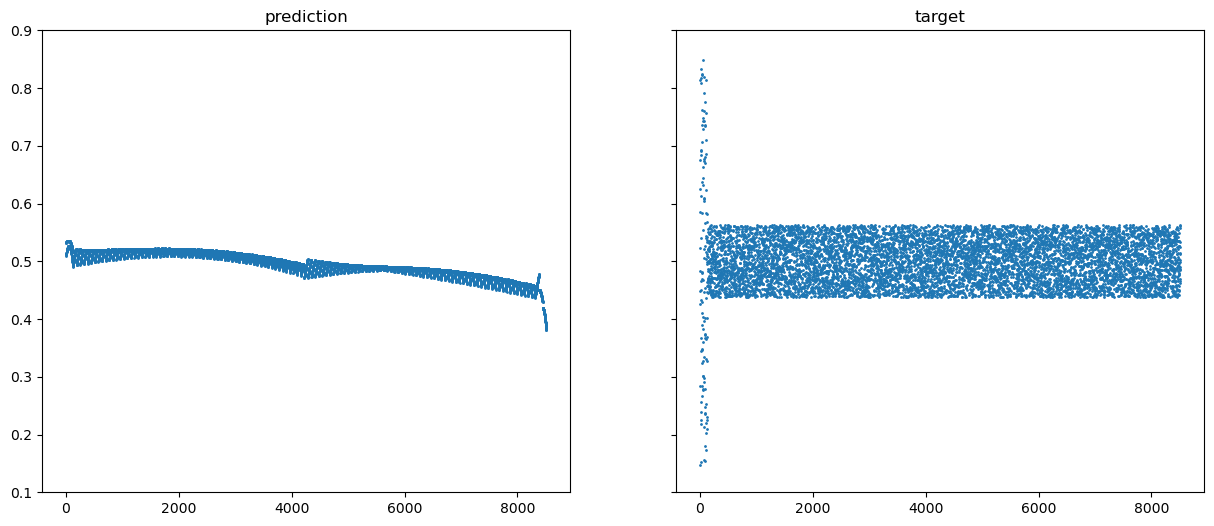

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_target_weights.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [18]:
prediction.mul_(2).sub_(1)
index_tracker = 0
cppn1 = CPPN1()
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

128
tensor([[ 0.0187,  0.0640],
        [ 0.0212,  0.0646],
        [ 0.0235,  0.0652],
        [ 0.0258,  0.0658],
        [ 0.0280,  0.0663],
        [ 0.0301,  0.0668],
        [ 0.0321,  0.0673],
        [ 0.0340,  0.0678],
        [ 0.0359,  0.0683],
        [ 0.0376,  0.0687],
        [ 0.0393,  0.0691],
        [ 0.0408,  0.0695],
        [ 0.0423,  0.0698],
        [ 0.0437,  0.0701],
        [ 0.0450,  0.0704],
        [ 0.0462,  0.0706],
        [ 0.0473,  0.0708],
        [ 0.0483,  0.0710],
        [ 0.0492,  0.0712],
        [ 0.0500,  0.0713],
        [ 0.0507,  0.0714],
        [ 0.0513,  0.0714],
        [ 0.0518,  0.0714],
        [ 0.0522,  0.0714],
        [ 0.0525,  0.0713],
        [ 0.0526,  0.0712],
        [ 0.0527,  0.0711],
        [ 0.0527,  0.0709],
        [ 0.0526,  0.0707],
        [ 0.0524,  0.0704],
        [ 0.0520,  0.0701],
        [ 0.0516,  0.0698],
        [ 0.0510,  0.0694],
        [ 0.0504,  0.0690],
        [ 0.0496,  0.0685],
        [ 0.0487